# ChromProcess Introduction, Part 3 (deconvolution)

ChromProcess has the capability of deconvoluting peaks by fitting a sum of multiple probability density functions to sections of a chromatogram.

This process will work better if some peak information (position, boundaries) is provided in advance. Running a peak picking operation as described in Part 1 should be sufficient to obtain this information.

Below is a workflow for 'deconvoluting' a region of a chromatogram.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ChromProcess.Loading import chrom_from_csv
from ChromProcess.Utils import deconvolution
from ChromProcess.Processing import find_peaks_in_region

Load an example chromatogram, define a region, and pick peaks.

In [2]:
data_file = (
    "example_data/Example/ExperimentalData/ExampleChromatograms/chrom_001.csv"
)

chrom = chrom_from_csv(data_file)

region = [10.25, 10.75]

peaks = find_peaks_in_region(chrom, *region, threshold=0.01, wlen = 10, distance =10)
chrom.add_peaks(peaks)

Run the deconvolution operation. Note that the number of peaks to be fitted can be specified, but it does not necessarily have to be the same as the number of peaks in the chromatogram. Preferably, the two are equal.

The result is an array with a row for each picked peak, containing the peak magnitude, position, standard deviation (width) and baseline.

In [3]:
deconvolution_result = deconvolution.deconvolute_region(chrom, region, num_peaks=4)
print(deconvolution_result)

Deconvolution warning: deconvoluting more peaks than specified.
[[5.08894580e+02 1.03200647e+01 1.15043138e-02 2.63948557e-16]
 [2.39797140e+03 1.03939730e+01 1.12877217e-02 2.63948557e-16]
 [8.91192644e+02 1.06109057e+01 1.82661439e-02 2.63948557e-16]
 [5.92372488e+03 1.06708915e+01 1.38192637e-02 2.63948557e-16]
 [2.91430554e+03 1.06874615e+01 8.47117714e-03 2.63948557e-16]]


Now plot the results.

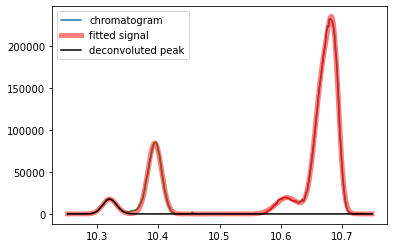

In [4]:
# Cut out the region of the chromatogram that was deconvoluted
inds = np.where((chrom.time > region[0]) & (chrom.time < region[1]))[0]

time = chrom.time[(chrom.time > region[0])&(chrom.time< region[1])]
signal = chrom.signal[(chrom.time > region[0])&(chrom.time< region[1])]

plt.plot(time, signal, label = "chromatogram")

for p in chrom.peaks:
    peak = chrom.peaks[p]
    plt.plot(chrom.time[peak.indices], chrom.signal[peak.indices])

plt.plot(
    time,
    deconvolution.pdf(
        np.tile(
                time, 
                (deconvolution_result.shape[0], 1)
               ).T
                , 
                deconvolution_result[:,0], 
                deconvolution_result[:,1],
                deconvolution_result[:,2],
                deconvolution_result[:,3]
    ),
    label = "fitted signal",
    # Some parameters to emphasise where the deconvolution is
    c="r",
    alpha = 0.5,
    linewidth = 5
)

# Obtaining a single peak from the fit
single_peak = deconvolution_result[:1]

plt.plot(time, deconvolution.pdf(
                                np.tile(time, (single_peak.shape[0],1)).T, 
                                single_peak[:,0],
                                single_peak[:,1],
                                single_peak[:,2],
                                single_peak[:,3]
                                ),
         c= "k",
         label = "deconvoluted peak"
        )
plt.legend()
plt.show()

That's one way of doing it. Other deconvolution methods are possible. Kernel Density Estimation (KDE) and Gaussian are related methods (which may effectively be the same? They seem to be identical in principle). Multidimensional methods include Biller and Bielmann (1974) and using PARAFAC ([tensorly](http://tensorly.org/stable/index.html) provides a convenient interface to PARAFAC, as used in [Mocca](https://github.com/HaasCP/mocca)).